In [1]:
!mkdir -p model
# !pip install scikit-plot > /dev/null

In [2]:
import numpy as np
import os,time
import cv2
import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/py

In [3]:
batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 10
num_classes = 10

In [4]:
class ProcessData:
    def __init__(self, train, test, val, num_classes=10, original_shape=(28,28), final_shape=(32,32)):
        self.num_classes = num_classes
        self.original_shape = original_shape
        self.final_shape = final_shape
        (x_train,y_train) = train
        (x_test,y_test) = test
        (x_val,y_val) = val
        ((self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val)) = map(self.reshape_dims, [train, test, val])

    def reshape_dims(self, d):
        (x,y) = d
        x = x.astype('float32')
        x = x.reshape(x.shape[0], self.original_shape[0], self.original_shape[1], 1)
        pad_0 = int((self.final_shape[0]-self.original_shape[0])/2)
        pad_1 = int((self.final_shape[1]-self.original_shape[1])/2)
        x = np.pad(x, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x = np.stack((x,)*3, axis=-1)
        x = x[:,:,:,0,:]
        y = keras.utils.to_categorical(y, self.num_classes)
        return x, y

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape,y_test.shape)
data = ProcessData((x_train, y_train), (x_test, y_test), (x_val, y_val), num_classes=10, original_shape=(28,28), final_shape=(224,224))
print(data.x_train.shape,data.y_train.shape)
print(data.x_val.shape, data.y_val.shape)
print(data.x_test.shape,data.y_test.shape)

(40200, 28, 28) (40200,)
(19800, 28, 28) (19800,)
(10000, 28, 28) (10000,)
(40200, 224, 224, 3) (40200, 10)
(19800, 224, 224, 3) (19800, 10)
(10000, 224, 224, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


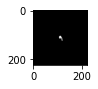

In [6]:
import random
%matplotlib inline

index = random.randint(0, len(data.x_train))
image = data.x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [7]:
print("Train shape",data.x_train.shape, y_train.shape)
print("Val shape",data.x_val.shape, y_val.shape)
print("Test shape",data.x_test.shape, y_test.shape)

Train shape (40200, 224, 224, 3) (40200,)
Val shape (19800, 224, 224, 3) (19800,)
Test shape (10000, 224, 224, 3) (10000,)


In [8]:
def inception(x, filters):
    # 1x1
    path1 = layers.Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = layers.Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = layers.Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = layers.MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = layers.Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return layers.Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, num_classes,name=None):
    layer = layers.AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = layers.Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(units=256, activation='relu')(layer)
    layer = layers.Dropout(0.4)(layer)
    layer = layers.Dense(units=num_classes, activation='softmax', name=name)(layer)
    return layer


def googlenet(layer_in,num_classes):
#     layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = layers.BatchNormalization()(layer)

    # stage-2
    layer = layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = layers.Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, num_classes, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, num_classes, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = layers.AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = layers.Flatten()(layer)
    layer = layers.Dropout(0.4)(layer)
    layer = layers.Dense(units=256, activation='linear')(layer)
    main = layers.Dense(units=num_classes, activation='softmax', name='main')(layer)
    
    return main, aux1, aux2
#     model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
#     return model


In [9]:
input_shape = data.x_train.shape[1:]

inputs = layers.Input(shape=input_shape)
(main, aux1, aux2) = googlenet(inputs,num_classes)
# model = keras.models.Model(inputs=inputs, outputs=model_output)
model = keras.models.Model(inputs=inputs, outputs=[main, aux1, aux2])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
                 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_1[0][0]            
____________________

In [10]:
plot_model(model, to_file='model/inception.png')

In [12]:
start = time.time()
history = model.fit(data.x_train, [data.y_train,data.y_train,data.y_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(data.x_val, [data.y_val,data.y_val,data.y_val]))
end = time.time()
total_exec_time = end - start

Instructions for updating:
Use tf.cast instead.
Train on 40200 samples, validate on 19800 samples
Epoch 1/10
40200/40200 [==============================] - 112s 3ms/step - loss: 1.4101 - main_loss: 0.5395 - aux1_loss: 0.4140 - aux2_loss: 0.4526 - main_accuracy: 0.8172 - aux1_accuracy: 0.8652 - aux2_accuracy: 0.8469 - val_loss: 0.6938 - val_main_loss: 0.2651 - val_aux1_loss: 0.2007 - val_aux2_loss: 0.2283 - val_main_accuracy: 0.9236 - val_aux1_accuracy: 0.9346 - val_aux2_accuracy: 0.9307
Epoch 2/10
40200/40200 [==============================] - 105s 3ms/step - loss: 0.2530 - main_loss: 0.0967 - aux1_loss: 0.0721 - aux2_loss: 0.0834 - main_accuracy: 0.9752 - aux1_accuracy: 0.9796 - aux2_accuracy: 0.9784 - val_loss: 0.5266 - val_main_loss: 0.2288 - val_aux1_loss: 0.1463 - val_aux2_loss: 0.1521 - val_main_accuracy: 0.9424 - val_aux1_accuracy: 0.9526 - val_aux2_accuracy: 0.9554
Epoch 3/10
40200/40200 [==============================] - 106s 3ms/step - loss: 0.1874 - main_loss: 0.0721 - aux1_

In [13]:
# Save the model weights.
weight_path = 'model/inception_wt.h5'
model.save_weights(weight_path)

In [20]:
score = model.evaluate(data.x_test, [data.y_test,data.y_test,data.y_test], verbose=1,batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[4])
print(score)

10000/10000 [==============================] - 11s 1ms/step
Test loss: 0.10269188071524259
Test accuracy: 0.03683982044458389
Test accuracy: [0.10269188071524259, 0.03683982044458389, 0.029731865972280502, 0.03498481586575508, 0.9909999966621399, 0.9916999936103821, 0.9911999702453613]


In [37]:
type(score)

list

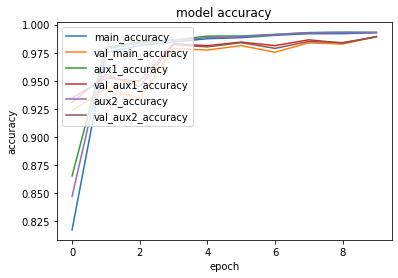

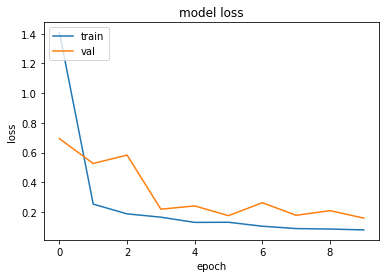

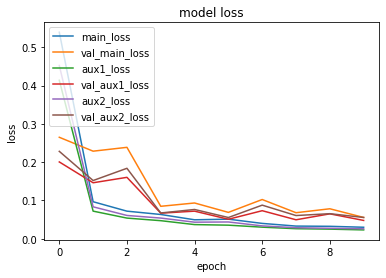

In [39]:
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.plot(history.history['aux1_accuracy'])
plt.plot(history.history['val_aux1_accuracy'])
plt.plot(history.history['aux2_accuracy'])
plt.plot(history.history['val_aux2_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['main_accuracy', 'val_main_accuracy','aux1_accuracy','val_aux1_accuracy','aux2_accuracy','val_aux2_accuracy'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.plot(history.history['aux1_loss'])
plt.plot(history.history['val_aux1_loss'])
plt.plot(history.history['aux2_loss'])
plt.plot(history.history['val_aux2_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['main_loss', 'val_main_loss','aux1_loss','val_aux1_loss','aux2_loss','val_aux2_loss'], loc='upper left')
plt.show()

In [26]:
predictions = model.predict(data.x_test, verbose=0)

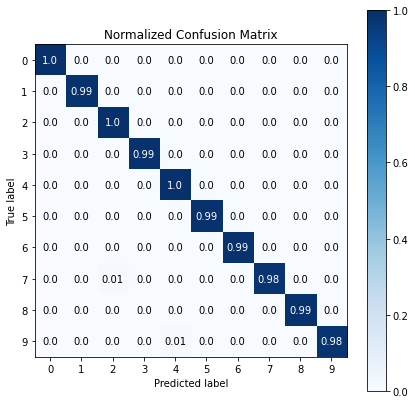

In [29]:
# from sklearn.metrics import classification_report, confusion_matrix
# confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1))
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions[0],axis=1), normalize=True,figsize = (7,7))

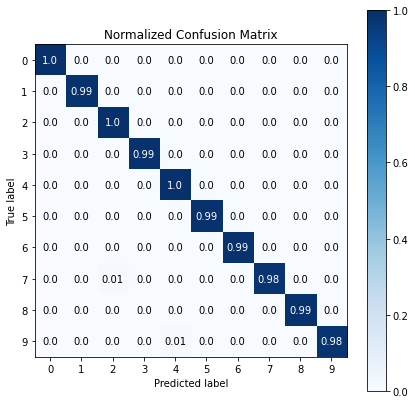

In [31]:
skplt.metrics.plot_confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions[2],axis=1), normalize=True,figsize = (7,7))

### Error Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

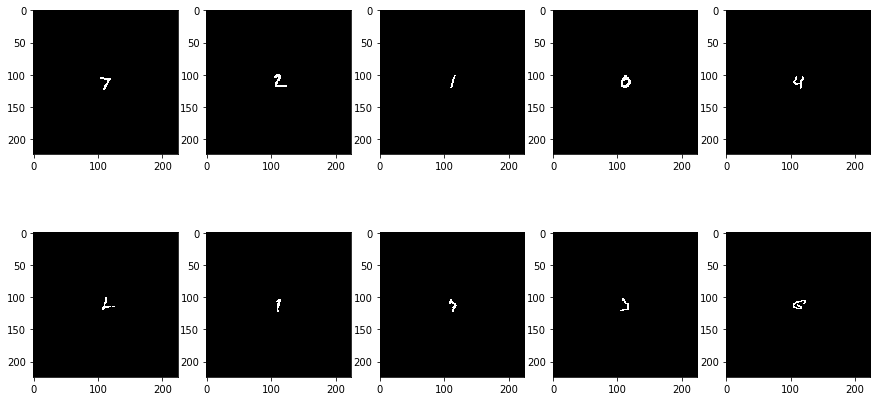

True:          [7 2 1 0 4]
classified as: [7 2 1 0 4]
Error
True:          [2 1 7 3 6]
classified as: [4 7 9 5 5]


In [36]:
def test_accuracy():
    err = []
    tru = []
    for i in range(predictions[0].shape[0]):
        if (np.argmax(predictions[0][i]) == y_test[i]):
            tru.append(i)
        else:
            err.append(i)
    return tru, err

p = test_accuracy()

fig1 = plt.figure(figsize = (15,15))
for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(data.x_test[p[0][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(data.x_test[p[1][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(np.argmax(data.y_test[p[0][0:5]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[0][p[0][0:5]], axis=1)))
print("Error Cases")
print("True:          {}".format(np.argmax(data.y_test[p[1][6:11]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[0][p[1][6:11]], axis=1)))

In [41]:
hist = {}
hist['model_name'] = 'VGG16'
hist['input_dims'] = data.x_train.shape[1:]
hist['training_time'] = total_exec_time
hist = dict(hist, **history.history)
hist['test_loss'] = score[0]
hist['test_accuracy'] = score[4]
np.save('model.txt',hist)

result = pd.DataFrame()
result = result.append(hist, ignore_index=True)
result

,aux1_accuracy,aux1_loss,aux2_accuracy,aux2_loss,input_dims,loss,main_accuracy,main_loss,model_name,test_accuracy,test_loss,training_time,val_aux1_accuracy,val_aux1_loss,val_aux2_accuracy,val_aux2_loss,val_loss,val_main_accuracy,val_main_loss
0,"[0.8652239, 0.9795522, 0.98455226, 0.98626864,...","[0.4139618, 0.07214648, 0.053974073, 0.0472065...","[0.84689057, 0.97838306, 0.9835323, 0.9864179,...","[0.45263106, 0.08343346, 0.060861364, 0.054031...","(224, 224, 3)","[1.4101210344668051, 0.2530039545589715, 0.187...","[0.8171642, 0.9752239, 0.9814428, 0.9845771, 0...","[0.5394552, 0.09671371, 0.07208996, 0.06339453...",VGG16,0.991,0.102692,0.0,"[0.9345959424972534, 0.9525757431983948, 0.949...","[0.2006649523973465, 0.14627039432525635, 0.16...","[0.9306565523147583, 0.9554040431976318, 0.945...","[0.22831863164901733, 0.15207837522029877, 0.1...","[0.6937707616825296, 0.5265618304291156, 0.583...","[0.923585832118988, 0.9424242377281189, 0.9345...","[0.26508399844169617, 0.2287691980600357, 0.23..."


In [42]:
K.clear_session()